In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [2]:
# basic imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

# tensorflow imports
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# own imports
from flow import load_data, select_dates, sales_to_money, select_final_day, create_submission, select_day_nums
from evaluation import Referee, RapidReferee, CrossValiDataGenerator
from agent import KDayMeanTimesWeeklyPattern, AggregateAgent
from train import BatchCreator, Logger

In [3]:
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions/'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for MacOS TF bug

# General settings for figures
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 13})  # 12, 16
plt.rcParams["savefig.bbox"] = 'tight'

# Top Down for M5Forecast - Accuracy - WRMSSE as loss function
This notebook investigates the Top Down approach for the M5Forecast - Accuracy challenge. Here, the aggregated sales of the stores are predicted directly by the model, instead of calculating the sales by aggregating product-level predictions.  

To match the training objective and validation metric, the WRMSSE is used as loss function. For simplicity, only the WRMSSE of the store level is computed. 

The WRMSSE, for a single level, is calculated as:  

$$
WRMSSE = \sum_{series} w_i \cdot RMSSE = \sum_{series} w_i \cdot \sqrt{\frac{1}{h}\frac{\sum_{days} E^2}{S_i}}
$$

Where $E$ denotes the prediction error, $Y_t - \hat Y_t$, and $S$ is a constant per series, computed as described in the M5 Competitors guide.  

During training, the sales are normalised. Let $c$ be the training normalisation constant for each series. Then $E^2 = c^2 \cdot E'^2$, with $E'$ the normalised prediction error.   

$$
WRMSSE = \sum_{series} w_i \cdot \sqrt{\frac{1}{h}\frac{c^2\cdot\sum_{days} E'^2}{S_i}}\\
= \sum_{series} w_i \cdot \sqrt{\frac{c^2}{S_i}}\cdot \sqrt{\frac{1}{h}\sum_{days} E'^2}\\
= \sum_{series} w_i \cdot \frac{c}{\sqrt{S_i}}\cdot RMSE'
$$

In [4]:
# Load data
calendar, sales_train_validation, sell_prices = load_data()

# Set up generator
cv_generator = CrossValiDataGenerator(sales_train_validation)
sales_train, sales_true = cv_generator.get_train_val_split(fold=10, train_size=-1)

# create referee for fold 10
ref = Referee(sales_true, sales_train, sell_prices, calendar)

Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
def preprocess(sales, prices=None, calendar=None, norm=None):
    """Convert sales to a suitable format for the BatchCreator"""
    # prices and calendar inputs are for compatibility
    
    # Calculate aggregated sales
    df = sales.groupby(['store_id']).sum()
    
    # Transpose sales such that d_num_start, ... is the index
    df = df.T
    
    # Normalize
    if norm is None:
        norm = df.max().max()
    df /= norm
    
    return df, norm

In [6]:
# Get suitable train df
train_df, train_norm = preprocess(sales_train)
features = train_df.columns

# Set up batch creator
window_in, window_out = 28, 28
batch_creator = BatchCreator(df=train_df, features=features, labels=features, 
                             window_in=window_in, window_out=window_out)

# Test if batch creator works
x, y = next(batch_creator.flow())
print("Input shape: {}, output shape: {}".format(x.shape, y.shape))
batch_creator.on_epoch_end()  # reset generator

Input shape: (32, 28, 10), output shape: (32, 28, 10)


In [7]:
def get_model(inp_shape, out_shape, loss='MSE'):
    # clear previous sessions
    K.clear_session()

    # add first layer with correct input size
    inp = Input(shape=inp_shape, name="input")
    x = Reshape((np.prod(inp_shape), 1))(inp)
    
    x = Conv1D( 8, kernel_size=3, padding="same", activation='relu')(x)
    x = Conv1D(16, kernel_size=3, padding="same", activation='relu')(x)
    x = Conv1D(32, kernel_size=3, padding="same", activation='relu')(x)

    out = Conv1D(1, kernel_size=1, activation='linear', name='output')(x)
    out = Reshape(out_shape)(out)
    
    model = Model(inputs=inp, outputs=out)

    model.compile(loss=loss, optimizer='adam', metrics=['MSE', loss])
    
    return model

model = get_model(inp_shape=(window_in, batch_creator.n_features), 
                  out_shape=(window_out, batch_creator.n_labels))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 10)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 280, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 280, 8)            32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 280, 16)           400       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 280, 32)           1568      
_________________________________________________________________
output (Conv1D)              (None, 280, 1)            33        
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 10)            0     

$$
WRMSSE = \sum_{series} w_i \cdot \sqrt{\frac{1}{h}\frac{c^2\cdot\sum_{days} E'^2}{S}}\\
= \sum_{series} w_i \cdot \sqrt{\frac{c^2}{S}}\cdot \sqrt{\frac{1}{h}\sum_{days} E'^2}\\
= \sum_{series} w_i \cdot \frac{c}{\sqrt{S}}\cdot MSE'
$$
When calculating the loss function, `y_true` and `y_pred` are $(28, 10)$ vectors. 

In [8]:
scaling = ref.weights[3] * train_norm / (ref.scales[3] ** (1/2))
scaling

store_id
CA_1    1.327991
CA_2    1.368305
CA_3    1.695968
CA_4    1.949779
TX_1    1.313764
TX_2    1.221120
TX_3    1.699876
WI_1    1.210031
WI_2    1.283828
WI_3    1.012163
dtype: float64

In [9]:
import tensorflow.keras.backend as K
import tensorflow as tf

def make_loss(ref):
    # calculate scaling constant for each series
    scaling = ref.weights[3] * train_norm / (ref.scales[3] ** (1/2))
    # convert to  array
    scaling = tf.Variable(scaling.values, dtype=tf.float32)
    def WRMSSE_store(y_true, y_pred):
        # calculate squared prediction error
        SE = K.square(y_pred - y_true)
        # Calculate mean of daily prediction errors, so keep list of series
        MSE = K.mean(SE, axis=0)
        # apply scaling
        scaled_MSE = MSE * scaling
        # sum
        return K.sum(scaled_MSE)
    return WRMSSE_store

WRMSSE_store_loss = make_loss(ref)

In [10]:
model = get_model(inp_shape=(window_in, batch_creator.n_features), 
                  out_shape=(window_out, batch_creator.n_labels),
                  loss=WRMSSE_store_loss)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 10)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 280, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 280, 8)            32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 280, 16)           400       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 280, 32)           1568      
_________________________________________________________________
output (Conv1D)              (None, 280, 1)            33        
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 10)            0     

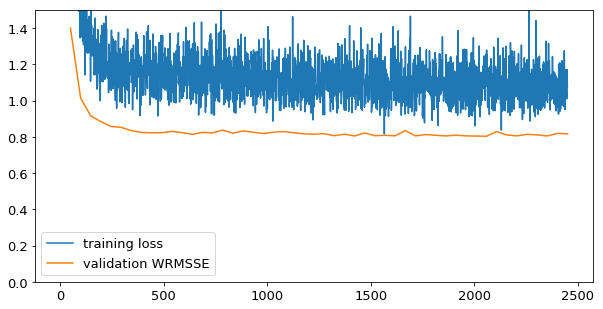

49/49 [==============================] - 6s 119ms/step - loss: 1.0813 - MSE: 0.0028 - WRMSSE_store: 1.0813


In [11]:
logger = Logger(ref=ref, cv_generator=cv_generator, train_norm=train_norm, features=features,
                agent=AggregateAgent(model=model, train_norm=train_norm, features=features, window_in=28),
                preprocess_func=preprocess, folds = np.arange(1, 1+10), plot_loss_max=1.5)

history = model.fit(batch_creator.flow(), epochs=50,
                    steps_per_epoch=batch_creator.n // batch_creator.batch_size,
                    callbacks=[logger])

## CNN - model prediction

In [12]:
# select days to predict
val_day_nums = select_day_nums(sales_true)
# setup agent with trained model
agent = AggregateAgent(model=model, train_norm=train_norm, features=features)

In [13]:
# predictions
sales_pred = agent.predict(train_df, val_day_nums)
sales_pred

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
d_1634,4204.353027,2922.893555,5997.525391,2302.864746,3030.706299,3482.757324,3385.387207,2799.491211,3651.706299,2946.447754
d_1635,4169.625488,2861.650879,5718.106934,2278.270752,2930.290039,3234.729980,3028.770996,3071.714600,3196.105957,2942.126709
d_1636,3864.910156,2924.720947,5397.151367,2092.231689,2845.336914,3342.826172,3092.516113,2963.136230,3025.654785,2746.011963
d_1637,3839.854736,2820.680908,5627.053711,2173.217285,2873.428955,3352.158203,3088.328857,3020.953369,3219.194336,2737.852051
d_1638,4104.978027,3423.871826,5864.219727,2533.080811,2999.927002,3590.445557,3381.791504,3454.288574,3515.946533,2912.243652
d_1639,4804.471680,4355.065430,6469.887695,2660.168457,3410.141357,4216.247559,3832.867920,3807.653320,3685.796631,3334.958252
d_1640,5263.741699,4326.842285,6818.910156,2759.097900,3515.614502,4094.196533,3999.040039,3723.415039,3181.406006,3364.172852
d_1641,4012.686035,2914.959229,5896.965332,2374.165527,2980.031250,3375.463135,3240.261475,3127.267090,3339.484131,2810.945801
d_1642,3984.715576,2807.039795,5616.395020,2278.228760,2858.173584,3029.763428,2783.117188,3017.079346,3299.989746,2813.648193
d_1643,4340.437012,3218.215820,6437.798828,2485.878662,3341.812988,3511.260986,3705.881104,3323.003662,3981.664307,3107.321533


In [14]:
# evaluate model on final 10 folds
WRMSSE_mean, WRMSSE_list = logger.validate()
print("Mean WRMSSE level 3: {}".format(WRMSSE_mean))

Mean WRMSSE level 3: 0.8164540156659891


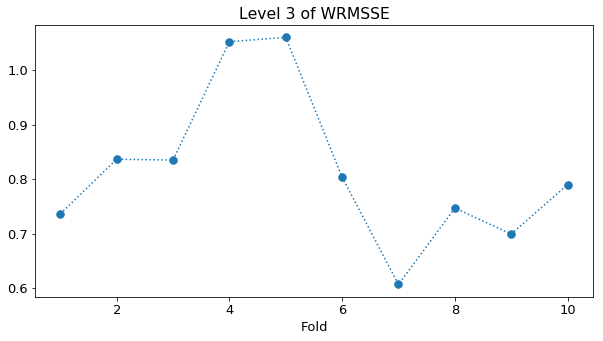

In [15]:
f, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(WRMSSE_list))+1, WRMSSE_list, '.:', ms=15)
ax.set_xlabel("Fold")
ax.set_title("Level 3 of WRMSSE")
plt.show()

## Keep week order constant

In [22]:
model = get_model(inp_shape=(window_in, batch_creator.n_features), 
                  out_shape=(window_out, batch_creator.n_labels),
                  loss=WRMSSE_store_loss)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 10)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 280, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 280, 8)            32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 280, 16)           400       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 280, 32)           1568      
_________________________________________________________________
output (Conv1D)              (None, 280, 1)            33        
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 10)            0     

In [23]:
batch_creator.list_start_val_days = np.array([d for d in batch_creator.list_start_val_days if d%7==0])
batch_creator.n = len(batch_creator.list_start_val_days)
batch_creator.on_epoch_end()

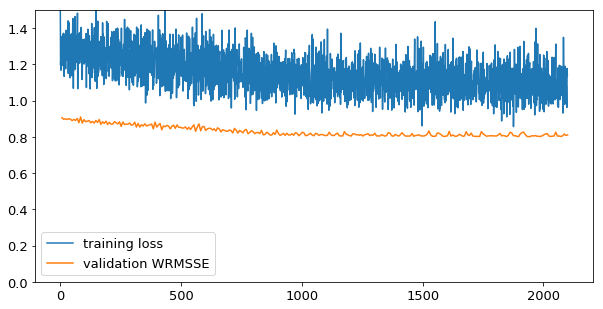

7/7 [==============================] - 1s 199ms/step - loss: 1.0830 - MSE: 0.0028 - WRMSSE_store: 1.0830


In [26]:
logger = Logger(ref=ref, cv_generator=cv_generator, train_norm=train_norm, features=features,
                agent=AggregateAgent(model=model, train_norm=train_norm, features=features, window_in=window_in),
                preprocess_func=preprocess, folds = np.arange(1, 1+10), plot_loss_max=1.5)

history = model.fit(batch_creator.flow(), epochs=200,
                    steps_per_epoch=batch_creator.n // batch_creator.batch_size,
                    callbacks=[logger])

Mean WRMSSE level 3: 0.8102354179824649


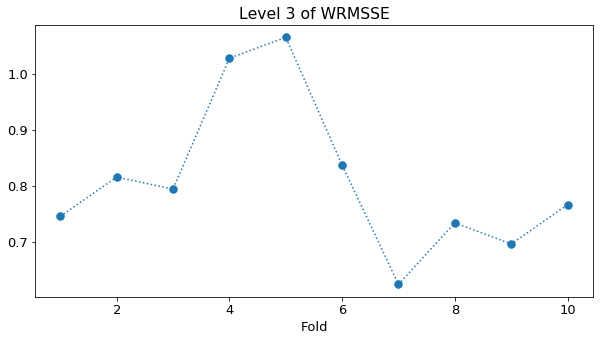

In [27]:
# evaluate model on final 10 folds
WRMSSE_mean, WRMSSE_list = logger.validate()
print("Mean WRMSSE level 3: {}".format(WRMSSE_mean))

f, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(WRMSSE_list))+1, WRMSSE_list, '.:', ms=15)
ax.set_xlabel("Fold")
ax.set_title("Level 3 of WRMSSE")
plt.show()